# Predict BTC price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [3]:
# Read in combined BTC Google trends data
btc_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_google_trends/btc_trends_combined.csv', parse_dates=True)
btc_google_trends.reset_index(inplace=True)
btc_google_trends.rename(columns={'date':'time', 'bitcoin':'BTC_Trends'},inplace=True)
btc_google_trends = btc_google_trends.drop(columns='index')
btc_google_trends['time'] = pd.to_datetime(btc_google_trends['time']).dt.date
btc_google_trends = btc_google_trends.set_index('time')
btc_google_trends.tail()

,BTC_Trends
time,
2021-07-30,20
2021-07-31,21
2021-08-01,21
2021-08-02,19
2021-08-03,19


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
211,2021-07-31 00:00:00+00:00,btc,720022,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354,4.391587e+09,11.383878
212,2021-08-01 00:00:00+00:00,btc,695892,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234,8.526051e+09,11.373743
213,2021-08-02 00:00:00+00:00,btc,899861,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019,7.278485e+09,11.491496
214,2021-08-03 00:00:00+00:00,btc,820918,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833,8.734047e+09,11.454489
215,2021-08-04 00:00:00+00:00,btc,842870,1.995698,7.468054e+11,9.800460e+07,57.964298,39773.911349,1.877626e+07,237723,1.288389e+10,11.498698


In [5]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [6]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [7]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/btc_annual_metrics/combined.csv')

In [8]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,btc_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends
time,,,,,,,,,,,,
2021-07-30,btc,841162.0,2.099162,7.844553e+11,1.128249e+08,75.598150,41789.667098,1.877151e+07,250833.0,1.037665e+10,11.390693,20.0
2021-07-31,btc,720022.0,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354.0,4.391587e+09,11.383878,21.0
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,11.373743,21.0
2021-08-02,btc,899861.0,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019.0,7.278485e+09,11.491496,19.0
2021-08-03,btc,820918.0,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833.0,8.734047e+09,11.454489,19.0


In [9]:
# Read in Relative Strength(RSI) data
rsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_btc.csv', parse_dates=True, index_col='time')
rsi_btc.head()

,RSI_14
time,
2010-08-01,39.307936
2010-08-02,38.416515
2010-08-03,38.433124
2010-08-04,35.864378
2010-08-05,41.466498


In [10]:
# Read in Rate of Change (ROC) data
roc_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_btc.csv', parse_dates=True, index_col='time')
roc_btc.head()

,ROC_14
time,
2010-08-01,-28.821062
2010-08-02,-25.742574
2010-08-03,-19.700856
2010-08-04,-28.003890
2010-08-05,4.327433


In [11]:
# Read in Money Flow Index (MFI) data
mfi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_btc.csv', parse_dates=True)
mfi_btc = mfi_btc.rename(columns={'Date':'time'})
mfi_btc['time'] = pd.to_datetime(mfi_btc['time']).dt.date
mfi_btc = mfi_btc.set_index('time').dropna()
mfi_btc.head()

,MFI_14
time,
2014-09-30,44.385818
2014-10-01,47.723240
2014-10-02,49.685391
2014-10-03,50.938482
2014-10-04,41.150663


In [12]:
# Read in Stochastic Oscilator (STOCH) data
stoch_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/stoch_btc.csv', parse_dates=True)
stoch_btc = stoch_btc.rename(columns={'Date':'time'})
stoch_btc['time'] = pd.to_datetime(stoch_btc['time']).dt.date
stoch_btc = stoch_btc.set_index('time').dropna()
stoch_btc

,STOCHk_14_3_3,STOCHd_14_3_3
time,,
2014-10-04,-37.509344,-25.445139
2014-10-05,-48.047226,-35.980253
2014-10-06,-50.582789,-45.379786
2014-10-07,-39.987669,-46.205895
2014-10-08,-26.924530,-39.164996
...,...,...
2021-08-01,77.269372,80.693512
2021-08-02,78.305324,79.470796
2021-08-03,66.275098,73.949931


In [13]:
# Read in True Strength (TSI) data
tsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/tsi_btc.csv', parse_dates=True)
tsi_btc = tsi_btc.rename(columns={'Date':'time'})
tsi_btc['time'] = pd.to_datetime(tsi_btc['time']).dt.date
tsi_btc = tsi_btc.set_index('time').dropna()
tsi_btc

,TSI_13_25_13,TSIs_13_25_13
time,,
2010-07-19,-100.000000,-100.000000
2010-07-20,-100.000000,-100.000000
2010-07-21,-98.061612,-99.723087
2010-07-22,-96.664148,-99.286096
2010-07-23,-94.755411,-98.638855
...,...,...
2021-07-31,26.872413,5.210707
2021-08-01,27.518611,8.397551
2021-08-02,27.054956,11.062894


In [14]:
# Create model features dataframe
features_btc = pd.concat([combined_df,rsi_btc, roc_btc, mfi_btc,stoch_btc,tsi_btc], axis=1).dropna()
features_btc.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends,RSI_14,ROC_14,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,TSI_13_25_13,TSIs_13_25_13
time,,,,,,,,,,,,,,,,,,,
2014-10-04,btc,172315.0,0.948455,4.388683e+09,265346.439578,67.045034,328.826113,1.334651e+07,66820.0,6.545873e+07,19.587453,41.0,24.193128,-20.001694,41.150663,-37.509344,-25.445139,-38.614390,-34.836375
2014-10-05,btc,247567.0,0.931729,4.309969e+09,291191.872004,41.507963,322.826262,1.335074e+07,66118.0,1.038348e+08,19.610506,53.0,23.351486,-19.374973,37.436477,-48.047226,-35.980253,-41.043432,-35.723097
2014-10-06,btc,193513.0,0.950872,4.364384e+09,277407.641377,49.778147,326.803533,1.335476e+07,78947.0,8.767671e+07,19.650973,59.0,25.208925,-18.478794,42.705205,-50.582789,-45.379786,-42.407186,-36.677967
2014-10-07,btc,200932.0,0.971547,4.455869e+09,230885.863009,73.747440,333.570195,1.335811e+07,77172.0,6.042066e+07,19.647726,53.0,28.388489,-23.927838,41.847111,-39.987669,-46.205895,-42.573212,-37.520145
2014-10-08,btc,189881.0,1.031950,4.735490e+09,248116.151294,55.661151,354.407334,1.336171e+07,79002.0,8.507711e+07,19.655439,41.0,37.236993,-16.354199,43.590115,-26.924530,-39.164996,-39.906766,-37.861091


In [15]:
features_btc.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_btc.csv')

<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

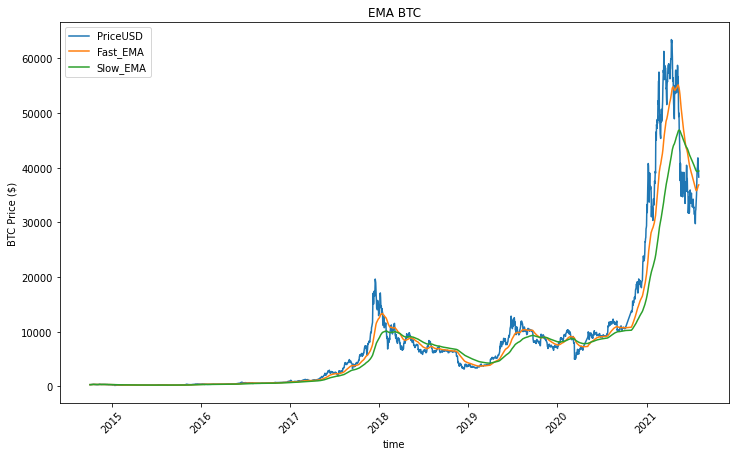

In [16]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals features
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_btc['Fast_EMA'] = features_btc['PriceUSD'].ewm(halflife=short_window).mean()
features_btc['Slow_EMA'] = features_btc['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_btc[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [17]:
# Construct a crossover trading signal
features_btc['Crossover_Long'] = np.where(features_btc['Fast_EMA'] > features_btc['Slow_EMA'], 1.0, 0.0)
features_btc['Crossover_Short'] = np.where(features_btc['Fast_EMA'] < features_btc['Slow_EMA'],-1.0, 0.0)
features_btc['Crossover_Signal'] = features_btc['Crossover_Long'] + features_btc['Crossover_Short']

In [18]:
# Calculate daily return
features_btc['Daily_Return'] = features_btc['PriceUSD'].pct_change()

In [19]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_btc['Positive_Return'] = np.where(features_btc['Daily_Return'] > 0, 1.0, 0.0)

features_btc = features_btc.dropna()

# Convert date to str to set test and train windows 
features_btc.index = pd.to_datetime(features_btc.index, format = '%Y/%m/%d')
features_btc.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,...,STOCHd_14_3_3,TSI_13_25_13,TSIs_13_25_13,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,,
2021-07-30,btc,841162.0,2.099162,7.844553e+11,1.128249e+08,75.598150,41789.667098,1.877151e+07,250833.0,1.037665e+10,...,78.937355,22.680252,1.600423,36427.015694,39371.969643,0.0,-1.0,-1.0,0.042496,1.0
2021-07-31,btc,720022.0,2.098153,7.845650e+11,1.126706e+08,178.651798,41793.313748,1.877250e+07,204354.0,4.391587e+09,...,82.137430,26.872413,5.210707,36609.811506,39405.305003,0.0,-1.0,-1.0,0.000087,1.0
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,...,80.693512,27.518611,8.397551,36724.236740,39413.065131,0.0,-1.0,-1.0,-0.043652,0.0
2021-08-02,btc,899861.0,1.972934,7.379108e+11,1.030490e+08,101.382469,39304.186284,1.877436e+07,236019.0,7.278485e+09,...,79.470796,27.054956,11.062894,36812.119293,39411.566163,0.0,-1.0,-1.0,-0.016632,0.0
2021-08-03,btc,820918.0,1.922865,7.188885e+11,1.217851e+08,82.308751,38288.825398,1.877541e+07,246833.0,8.734047e+09,...,73.949931,25.218734,13.085157,36862.421324,39396.109060,0.0,-1.0,-1.0,-0.025833,0.0


In [20]:
# Select model features and timeframe for train data
X = features_btc[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','BTC_Trends','RSI_14','ROC_14','MFI_14','STOCHk_14_3_3','STOCHd_14_3_3','TSI_13_25_13','TSIs_13_25_13']]
X_train = X[:'2020']

In [21]:
# Select prediction variable and timeframe for train data
y = features_btc['Positive_Return']
y_train = y[:'2020']

In [22]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [23]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [24]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [25]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.690625 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}


In [27]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500, n_jobs=-1)

In [28]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [29]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [30]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [31]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,40,62
Actual 1,11,102


Accuracy Score : 0.6604651162790698
Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.39      0.52       102
         1.0       0.62      0.90      0.74       113

    accuracy                           0.66       215
   macro avg       0.70      0.65      0.63       215
weighted avg       0.70      0.66      0.64       215



In [32]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-07-15,0.0,1.0
2021-07-16,0.0,1.0
2021-07-17,1.0,1.0
2021-07-18,1.0,1.0
2021-07-19,0.0,1.0
2021-07-20,0.0,0.0
2021-07-21,1.0,1.0
2021-07-22,1.0,1.0
2021-07-23,1.0,1.0


In [33]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.1819200411435332, 'RSI_14'),
 (0.08532379025059147, 'STOCHd_14_3_3'),
 (0.08331380298003752, 'TSI_13_25_13'),
 (0.08090124958021665, 'STOCHk_14_3_3'),
 (0.06841934430517492, 'ROC_14'),
 (0.0635728582961549, 'MFI_14'),
 (0.059964046873770396, 'TSIs_13_25_13'),
 (0.0484839554821775, 'NVTAdj'),
 (0.04536169980311046, 'CapMVRVCur'),
 (0.0440695402910888, 'TxCnt'),
 (0.04316273093823778, 'AdrActCnt'),
 (0.040966187002119965, 'VelCur1yr'),
 (0.03921756009645233, 'TxTfrValAdjUSD'),
 (0.03843947755343512, 'BTC_Trends'),
 (0.03737509404350754, 'HashRate'),
 (0.03735986138565455, 'CapMrktCurUSD'),
 (0.0021487599747368885, 'Crossover_Signal')]

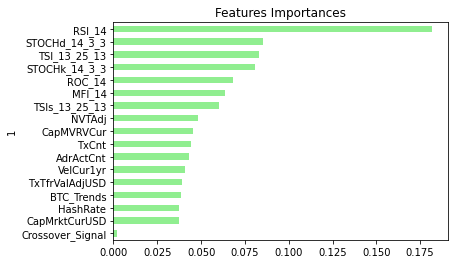

In [34]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that BTC price is primarily determined by momentum.